In [1]:
import random

from keyname import keyname as kn
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from slugify import slugify
import statsmodels.api as sm
import statsmodels.formula.api as smf
from teeplot import teeplot as tp
import itertools as it
import matplotlib.patheffects as pe


In [2]:
np.random.seed(1)
random.seed(1)


In [3]:
from conduitpylib.viz import _get_defaults as cfg

from conduitpylib.viz import beleaguerment_facetplot, beleaguerment_regplot

from conduitpylib.wrangle import (
    retrieve_and_prepare_delta_dataframes,
    wrangle_instrumentation_longform,
)


<Figure size 72x72 with 0 Axes>

In [4]:
nbm.print_metadata()


context: ci
hostname: 545621fc89b4
interpreter: 3.8.10 (default, Nov 22 2023, 10:22:35)  [GCC 9.4.0]
nbcellexec: 4
nbname: None
nbpath: None
revision: null
session: 94697757-d9f0-4f78-8404-e2cb7fba7c38
timestamp: 2023-11-30T19:19:01Z00:00


IPython==7.16.1
keyname==0.5.6
yaml==5.4.1
matplotlib==3.5.2
nbmetalog==0.2.6
numpy==1.23.5
pandas==1.1.2
scipy==1.5.4
seaborn==0.13.0
statsmodels==0.12.2
teeplot==0.6.1
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.2.1
json==2.0.9
six==1.15.0
ipykernel==5.5.3


# Get Data


In [5]:
def apply(df: pd.DataFrame) -> pd.DataFrame:
    row_distiller = lambda row: {
        k: v for k, v in row.items() if k in ("Num Nodes", "Num Processes")
    }
    df["Multiprocessing"] = df.apply(
        lambda row: {
            frozenset(
                {"Num Nodes": 1, "Num Processes": 2}.items()
            ): "Intranode",
            frozenset(
                {"Num Nodes": 2, "Num Processes": 2}.items()
            ): "Internode",
        }[frozenset(row_distiller(row).items())],
        axis=1,
    )
    return df


longitudinal_df, snapshot_df = retrieve_and_prepare_delta_dataframes(
    df_inlet_url="https://osf.io/4ys9v/download",
    df_outlet_url="https://osf.io/aum7w/download",
    apply=apply,
    treatment_column="Multiprocessing",
)


a: df_inlet
digest: 88ea77703064cb719aeda435a8ce9b2a07b6f22418808c27ef05c3f5bce64932
num cols: 42
num cols all na: 2
num cols any na: 42
num na: 1102
num rows: 521
num rows all na: 1
num rows any na: 521
size: 407K

a: df_outlet
digest: 8fcf036a2446e952bf3bafdbf5f4e9b45cdd9f566a38ec513e19fbe98353d22b
num cols: 68
num cols all na: 6
num cols any na: 68
num na: 3220
num rows: 521
num rows all na: 1
num rows any na: 521
size: 514K

df_inlet has 1 na rows, dropping them
df_outlet has 1 na rows, dropping them


# Compare Finalized and Rolling Measures


teeplots/./hue=instrumentation+treatment=internode+viz=beleaguerment-facetplot+x=messages-received-per-second+y=messages-sent-per-second+ext=.pdf
skipping teeplots/./hue=instrumentation+treatment=internode+viz=beleaguerment-facetplot+x=messages-received-per-second+y=messages-sent-per-second+ext=.png
teeplots/./hue=instrumentation+treatment=intranode+viz=beleaguerment-facetplot+x=messages-received-per-second+y=messages-sent-per-second+ext=.pdf
skipping teeplots/./hue=instrumentation+treatment=intranode+viz=beleaguerment-facetplot+x=messages-received-per-second+y=messages-sent-per-second+ext=.png


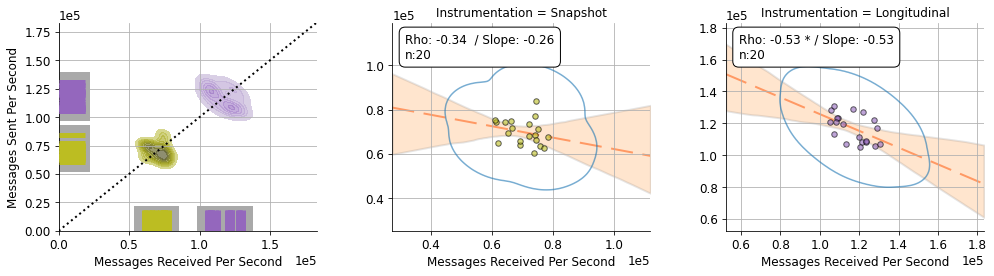

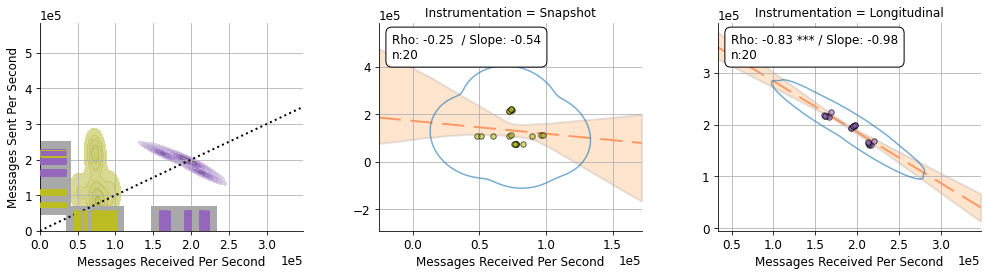

In [6]:
data = wrangle_instrumentation_longform(
    longitudinal_df=longitudinal_df,
    snapshot_df=snapshot_df,
)

for treatment, group in data.groupby("Multiprocessing"):
    group_df = group.reset_index()
    tp.tee(
        beleaguerment_facetplot,
        data=group_df,
        x="Messages Received Per Second",
        y="Messages Sent Per Second",
        hue="Instrumentation",
        annotation_kwargs=dict(
            xy=(0.05, 0.95),
        ),
        scatter_kwargs=dict(
            alpha=0.6,
            s=30,
            zorder=999,
        ),
        kde_kwargs=dict(
            cut=10,
            kde_thresh=1e-3,
        ),
        regline_kwargs=dict(
            linewidth=6,
            zorder=-9999,
        ),
        teeplot_outattrs={
            "treatment": slugify(treatment),
        },
    )
